In [0]:
!mkdir src -p && cd src && git clone https://github.com/fastai/fastai.git
!pip3 install -q -U pillow==4.1.1
!pip3 install -q bcolz graphviz sklearn_pandas isoweek pandas_summary ipywidgets torch torchvision torchtext pillow

Cloning into 'fastai'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20083 (delta 10), reused 9 (delta 3), pack-reused 20063
Receiving objects: 100% (20083/20083), 345.30 MiB | 26.72 MiB/s, done.
Resolving deltas: 100% (13801/13801), done.
Checking out files: 100% (741/741), done.
tcmalloc: large alloc 1073750016 bytes == 0x61b6a000 @  0x7f38a24132a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# fastai 0.7.0
import sys
sys.path.append("/content/src/fastai/old") # on windows use \'s instead

from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

print(torch.__version__)
torch.backends.cudnn.benchmark=True
torch.cuda.is_available(), torch.backends.cudnn.enabled

1.0.0


(True, True)

## Pascal VOC 2012

In [0]:
PATH = Path('data/pascal')
os.makedirs(PATH, exist_ok=True)

In [0]:
!cd {PATH} && curl --header "Host: host.robots.ox.ac.uk" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.62 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header "Accept-Language: zh,zh-CN;q=0.9,zh-TW;q=0.8,en-US;q=0.7,en;q=0.6" --header "Referer: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html" "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar" -o "VOCtrainval_11-May-2012.tar" -L
!cd {PATH} && tar xf VOCtrainval_11-May-2012.tar
!find {PATH} -type d

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1907M  100 1907M    0     0   102M      0  0:00:18  0:00:18 --:--:--  102M
data/pascal
data/pascal/VOCdevkit
data/pascal/VOCdevkit/VOC2012
data/pascal/VOCdevkit/VOC2012/SegmentationObject
data/pascal/VOCdevkit/VOC2012/Annotations
data/pascal/VOCdevkit/VOC2012/JPEGImages
data/pascal/VOCdevkit/VOC2012/SegmentationClass
data/pascal/VOCdevkit/VOC2012/ImageSets
data/pascal/VOCdevkit/VOC2012/ImageSets/Segmentation
data/pascal/VOCdevkit/VOC2012/ImageSets/Main
data/pascal/VOCdevkit/VOC2012/ImageSets/Action
data/pascal/VOCdevkit/VOC2012/ImageSets/Layout


In [0]:
!ls data/pascal/VOCdevkit/VOC2012/JPEGImages | head -5

2007_000027.jpg
2007_000032.jpg
2007_000033.jpg
2007_000039.jpg
2007_000042.jpg


In [0]:
!ls data/pascal/VOCdevkit/VOC2012/Annotations | head -5

2007_000027.xml
2007_000032.xml
2007_000033.xml
2007_000039.xml
2007_000042.xml


In [0]:
!cd {PATH} && wget -q https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
!cd {PATH} && unzip -q PASCAL_VOC.zip
list((PATH/'PASCAL_VOC/').iterdir())

[PosixPath('data/pascal/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/pascal/PASCAL_VOC/pascal_test2007.json')]

In [0]:
JPEG_PATH = 'VOCdevkit/VOC2012/JPEGImages'
IMG_PATH = PATH/JPEG_PATH
METADATA_PATH = PATH/'PASCAL_VOC'

In [0]:
trn_json = json.load((METADATA_PATH/'pascal_train2012.json').open())
val_json = json.load((METADATA_PATH/'pascal_val2012.json').open())
trn_json.keys(), val_json.keys()

(dict_keys(['images', 'type', 'annotations', 'categories']),
 dict_keys(['images', 'type', 'annotations', 'categories']))

## EDA

In [0]:
i = 0

print("images:")
display(val_json['images'][i])
print("\nannotations:")
display(val_json['annotations'][i])
print("\ncategories:")
display(val_json['categories'][i])
print("\ntype:")
display(val_json['type'][i])

images:


{'file_name': '2008_000002.jpg', 'height': 375, 'id': 2008000002, 'width': 500}


annotations:


{'area': 117445,
 'bbox': [33, 10, 415, 283],
 'category_id': 20,
 'id': 1,
 'ignore': 0,
 'image_id': 2008000002,
 'iscrowd': 0,
 'segmentation': [[33, 10, 33, 293, 448, 293, 448, 10]]}


categories:


{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'}


type:


'i'

In [0]:
display(val_json['annotations'][:5])

[{'area': 117445,
  'bbox': [33, 10, 415, 283],
  'category_id': 20,
  'id': 1,
  'ignore': 0,
  'image_id': 2008000002,
  'iscrowd': 0,
  'segmentation': [[33, 10, 33, 293, 448, 293, 448, 10]]},
 {'area': 146965,
  'bbox': [45, 10, 455, 323],
  'category_id': 19,
  'id': 2,
  'ignore': 0,
  'image_id': 2008000003,
  'iscrowd': 0,
  'segmentation': [[45, 10, 45, 333, 500, 333, 500, 10]]},
 {'area': 1188,
  'bbox': [61, 189, 22, 54],
  'category_id': 15,
  'id': 3,
  'ignore': 0,
  'image_id': 2008000003,
  'iscrowd': 0,
  'segmentation': [[61, 189, 61, 243, 83, 243, 83, 189]]},
 {'area': 27392,
  'bbox': [0, 229, 428, 64],
  'category_id': 4,
  'id': 4,
  'ignore': 0,
  'image_id': 2008000007,
  'iscrowd': 0,
  'segmentation': [[0, 229, 0, 293, 428, 293, 428, 229]]},
 {'area': 4758,
  'bbox': [216, 160, 78, 61],
  'category_id': 10,
  'id': 5,
  'ignore': 0,
  'image_id': 2008000009,
  'iscrowd': 0,
  'segmentation': [[216, 160, 216, 221, 294, 221, 294, 160]]}]

In [0]:
i2clas = {o['id']:o['name'] for o in val_json['categories']}
i2fn = {o['id']:o['file_name'] for o in val_json['images']}
fnames = [o['file_name'] for o in val_json['images']]

In [ ]:
annos = collections.defaultdict(lambda: [])
for o in val_json['annotations']:
  if o['ignore'] == 0:
    annos[i2fn[o['image_id']]].append((o['bbox'], o['category_id']))

In [0]:
def show_img(ax, fpath):
  im = open_image(IMG_PATH/fnames[i])
  ax.imshow(im)
  ax.axis('off')

'bbox: [([5, 117, 484, 157], 6), ([335, 172, 29, 52], 15)]'

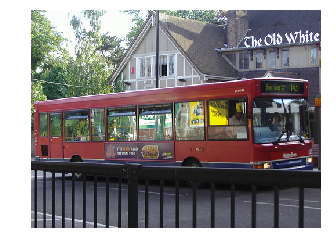

In [0]:
i = 8
fpath = IMG_PATH/fnames[i]
display('bbox: ' + str(annos[fnames[i]]))
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, fpath)

In [0]:
def draw_outline(patch, lw):
  patch.set_path_effects([ patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal() ])
  
def draw_bbox(ax, bbox, color='white'):
  patch = ax.add_patch(patches.Rectangle(bbox[:2], *bbox[2:], fill=False, edgecolor=color, lw=2))
  draw_outline(patch, 2)
  
def draw_txt(ax, xy, txt, sz=14):
  text = ax.text(*xy, txt, fontsize=sz, color='white', weight='bold', verticalalignment='top')
  draw_outline(text, 1)

def show_bbox(ax, bb):
  for b, c in bb:
    draw_bbox(ax, b, )
    draw_txt(ax, b[:2], i2clas[c])

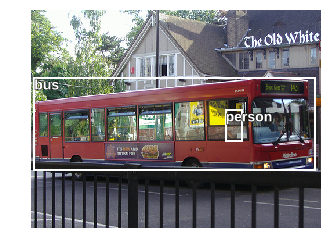

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, fpath)
show_bbox(ax, annos[fnames[i]])

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
  color_norm = mcolors.Normalize(0, N - 1)
  return cmx.ScalarMappable(color_norm, 'Set3').to_rgba

def show_bbox(ax, bb):
  for i, (b, c) in enumerate(bb):
    draw_bbox(ax, b, color=colors[i % NUM_COLORS])
    draw_txt(ax, b[:2], i2clas[c])
    
NUM_COLORS = 12
cmap = get_cmap(NUM_COLORS)
colors = [cmap(float(i)) for i in range(NUM_COLORS)]

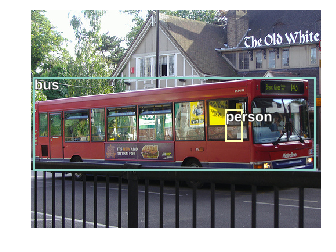

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, fpath)
show_bbox(ax, annos[fnames[i]])

## Prepare Data

In [0]:
len(trn_json['images']), len(val_json['images'])

(5717, 5823)

In [0]:
def get_annos(ds):
  annos = collections.defaultdict(lambda: [])
  i2fn = {o['id']:o['file_name'] for o in ds['images']}
  i2clas = {o['id']:o['name'] for o in val_json['categories']}
  for o in ds['annotations']:
    if o['ignore'] == 0:
      annos[i2fn[o['image_id']]].append((o['bbox'], i2clas[o['category_id']]))
  return annos

trn_annos = get_annos(trn_json)
val_annos = get_annos(val_json)

In [0]:
len(trn_annos), len(val_annos)

(5717, 5823)

In [0]:
train_annos = {}
for k, v in trn_annos.items():
  train_annos[k] = v
for k, v in val_annos.items():
  train_annos[k] = v

display(len(train_annos))
pickle.dump(train_annos, open(PATH/'train_annos.pkl', 'wb'))

11540

In [0]:
fnames = []
bboxes = []
claz = []

for k, v in train_annos.items():
  fnames.append(k)
  bb, clas = [], []
  for b, c in v:
    bb.append(b)
    clas.append(c)
  bboxes.append(' '.join([str(o) for o in np.concatenate(bb)]))
  claz.append(' '.join(clas))

train_bb_df = pd.DataFrame({'fname': fnames, 'bounding box': bboxes}, columns=['fname', 'bounding box'])
display(train_bb_df.head())
train_bb_df.to_csv(PATH/'train_bbox.csv', index=False)

train_clas_df = pd.DataFrame({'fname': fnames, 'class': claz}, columns=['fname', 'class'])
display(train_clas_df.head())
train_clas_df.to_csv(PATH/'train_clas.csv', index=False)

,fname,bounding box
0,2008_000008.jpg,52 86 419 334 157 43 132 124
1,2008_000015.jpg,269 0 109 176 56 0 108 150
2,2008_000019.jpg,138 1 234 196 164 65 154 171 360 0 120 112
3,2008_000023.jpg,5 0 309 262 39 96 82 315 136 35 33 74 179 35 3...
4,2008_000028.jpg,157 198 74 42 46 201 48 37


,fname,class
0,2008_000008.jpg,horse person
1,2008_000015.jpg,bottle bottle
2,2008_000019.jpg,dog dog dog
3,2008_000023.jpg,tvmonitor bottle person person person
4,2008_000028.jpg,car car


In [0]:
labels = np.unique(np.concatenate([o.split(' ') for o in claz]))
ltoi = {o:i for i, o in enumerate(labels)}
labels, len(labels)

(array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
       dtype='<U11'), 20)

In [0]:
val_idxs = get_cv_idxs(len(train_bb_df))
pickle.dump(val_idxs, open(PATH/'val_idxs.pkl', 'wb'))

## The Largest Object

### Prepare Data

In [0]:
def get_lrg_anno(anno):
  return sorted(anno, key=lambda x: x[0][2] * x[0][3], reverse=True)[0]

train_lrg_annos = {k:get_lrg_anno(v) for k, v in train_annos.items()}
pickle.dump(train_lrg_annos, open(PATH/'train_lrg_annos.pkl', 'wb'))

In [0]:
def show_lrg_bbox(ax, anno):
  draw_bbox(ax, anno[0], color=colors[i % NUM_COLORS])
  draw_txt(ax, anno[0][:2], anno[1])

def show_bbox(ax, bb):
  for i, (b, c) in enumerate(bb):
    draw_bbox(ax, b, color=colors[i % NUM_COLORS])
    draw_txt(ax, b[:2], c)

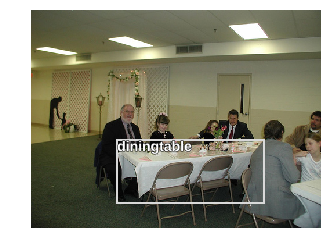

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, IMG_PATH/fnames[i])
show_lrg_bbox(ax, train_lrg_annos[fnames[i]])

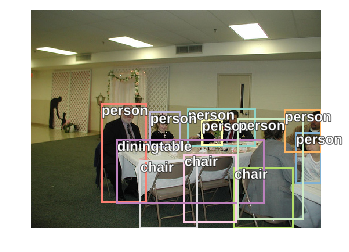

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, IMG_PATH/fnames[i])
show_bbox(ax, train_annos[fnames[i]])

In [0]:
# (y, x, y`, x`) -> (x, y, width, height) 
def from_bb(bb): return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

# (x, y, width, height) -> (y, x, y`, x`)
def to_bb(bb): return np.array([bb[1], bb[0], bb[1]+bb[3]-1, bb[0]+bb[2]-1])

In [0]:
fnames = []
bboxes = []
claz = []

for k, (b, c) in train_lrg_annos.items():
  fnames.append(k)
  bboxes.append(' '.join([str(o) for o in to_bb(b)]))
  claz.append(c)

train_lrg_bb_df = pd.DataFrame({'fname': fnames, 'bounding box': bboxes}, columns=['fname', 'bounding box'])
display(train_lrg_bb_df.head())
train_lrg_bb_df.to_csv(PATH/'train_lrg_bbox.csv', index=False)

train_lrg_clas_df = pd.DataFrame({'fname': fnames, 'class': claz}, columns=['fname', 'class'])
display(train_lrg_clas_df.head())
train_lrg_clas_df.to_csv(PATH/'train_lrg_clas.csv', index=False)

,fname,bounding box
0,2008_000008.jpg,86 52 419 470
1,2008_000015.jpg,0 269 175 377
2,2008_000019.jpg,1 138 196 371
3,2008_000023.jpg,0 5 261 313
4,2008_000028.jpg,198 157 239 230


,fname,class
0,2008_000008.jpg,horse
1,2008_000015.jpg,bottle
2,2008_000019.jpg,dog
3,2008_000023.jpg,tvmonitor
4,2008_000028.jpg,car


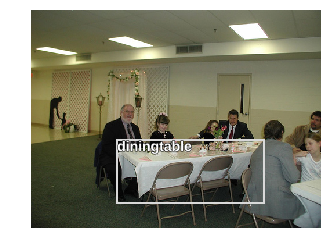

In [0]:
i = 8
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, IMG_PATH/fnames[i])
show_lrg_bbox(ax, (from_bb(np.array(train_lrg_bb_df.loc[i, 'bounding box'].split(' ')).astype(int)),
                   train_lrg_clas_df.loc[i, 'class']))

### Image Recognition

In [0]:
arch = resnet34
sz = 224
bs = 64
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_clas.csv', bs=bs, tfms=tfms, val_idxs=val_idxs)
md.c, np.array(md.classes)

(20,
 array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
       dtype='<U11'))

In [0]:
learn = ConvLearner.pretrained(arch, md)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 82511441.24it/s]


 80%|████████  | 116/145 [01:18<00:17,  1.68it/s, loss=5.43]

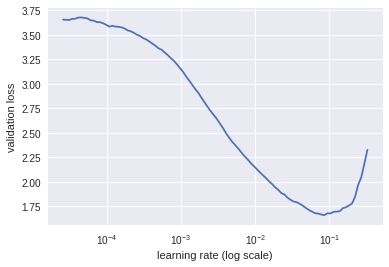

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr = 1e-2
learn.fit(lr, 1, cycle_len=2, use_clr=(10, 10))
learn.save('lrg_img_fz')

epoch      trn_loss   val_loss   accuracy   
    0      0.807189   0.615285   0.812825  
    1      0.599568   0.535633   0.840555  


In [0]:
learn.unfreeze()
lrs = np.array([lr / 100, lr / 10, lr])
learn.fit(lrs / 10, 1, cycle_len=2, use_clr=(20, 10))
learn.save('lrg_img')

epoch      trn_loss   val_loss   accuracy   
    0      0.601184   0.528094   0.836655  
    1      0.334767   0.498876   0.847487  


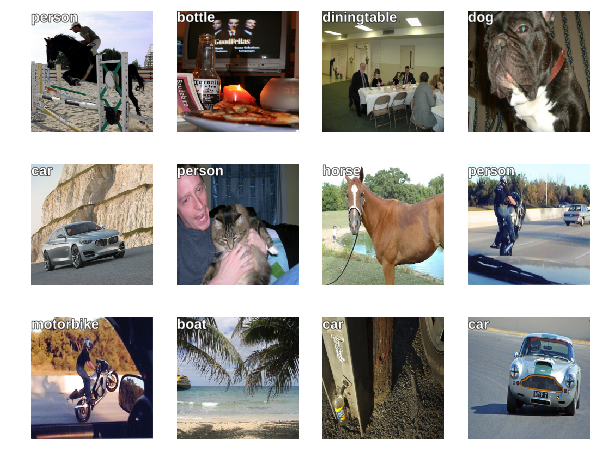

In [0]:
learn.load('lrg_img')
x, y = next(iter(learn.data.val_dl))
yp = predict_batch(learn.model, x)
x = learn.data.val_ds.denorm(x)
yl = labels[yp.max(1)[1].data.cpu().numpy()]

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(x[i])
  draw_txt(ax, (0, 0), yl[i])
  ax.axis('off')

### Bounding Box

In [0]:
arch = resnet34
sz = 224
bs = 64
aug_tfms = [
    RandomFlip(tfm_y=TfmType.COORD),
    RandomRotate(5, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)
]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_bbox.csv', bs=bs, tfms=tfms, val_idxs=val_idxs, continuous=True)
md.c

4

In [0]:
learn = ConvLearner.pretrained(arch, md)
learn.opt_fn = optim.Adam
learn.crit = F.l1_loss

 98%|█████████▊| 142/145 [02:10<00:01,  2.12it/s, loss=280]

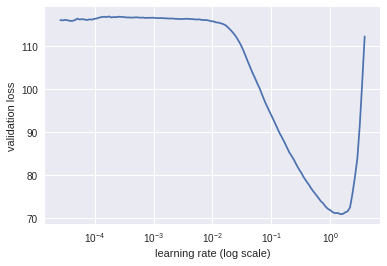

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr = 1e-1
learn.fit(lr, 1, cycle_len=3, use_clr=(10, 10))
learn.save('lrg_bbox_fz')

epoch      trn_loss   val_loss   
    0      31.633369  27.029304 
    1      28.608124  26.231282 
    2      27.359085  27.458307 


In [0]:
learn.load('lrg_bbox_fz')
learn.unfreeze()
lrs = np.array([lr / 100, lr / 10, lr])
learn.fit(lrs / 20, 1, cycle_len=4, use_clr=(10, 10))
learn.save('lrg_bbox')

epoch      trn_loss   val_loss   
    0      24.534589  23.231544 
    1      21.299118  46.510004 
    2      19.73664   17.859919 
    3      18.409843  16.747539 


### Object Detection： image recognition + bounding box

In [0]:
arch = resnet34
sz = 224
bs = 64
aug_tfms = [
    RandomFlip(tfm_y=TfmType.COORD),
    RandomRotate(5, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)
]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.COORD)
clas_md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_clas.csv', bs=bs, tfms=tfms, val_idxs=val_idxs)
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_bbox.csv', bs=bs, tfms=tfms, val_idxs=val_idxs,
                                       continuous=True)
c = md.c + clas_md.c

In [0]:
class ObjectDataset(Dataset):
  def __init__(self, ds, y): self.ds, self.y = ds, y
  def __getitem__(self, i):
    xi, yi = self.ds[i]
    return (xi, (yi, self.y[i]))
  @property
  def c(self): return c
  @property
  def is_multi(self): return False
  @property
  def is_reg(self): return True
  @property
  def sz(self): return sz

In [0]:
md.trn_dl.dataset = ObjectDataset(md.trn_ds, clas_md.trn_y)
md.val_dl.dataset = ObjectDataset(md.val_ds, clas_md.val_y)

In [0]:
x, y = next(iter(md.val_dl))
y[0].shape, y[1].shape

(torch.Size([64, 4]), torch.Size([64]))

In [0]:
nin = 7 * 7 * 512
nf = 512
ps = np.array([0.25, 0.5])

def custom_head():
  return nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(ps[0]),
    nn.Linear(nin, nf),
    nn.ReLU(),
    nn.Dropout(ps[1]),
    nn.Linear(nf, c)
)

custom_head_f = custom_head()

In [0]:
learn = ConvLearner.pretrained(arch, md, custom_head=custom_head_f)
learn.opt_fn = optim.Adam

In [0]:
def object_loss(preds, targs):
  bb_t, clas_t = targs
  bb_p = preds[:, :4]
  bb_p = F.sigmoid(bb_p) * sz
  clas_p = preds[:, 4:]
  return F.l1_loss(bb_p, bb_t) + F.cross_entropy(clas_p, clas_t) * 20

def clas_metric(preds, targs): return accuracy(preds[:, 4:], targs[1])

def bb_metric(preds, targs):
  bb_p = preds[:, :4]
  bb_p = F.sigmoid(bb_p) * sz
  return F.l1_loss(bb_p, targs[0])

In [0]:
learn.crit = object_loss
learn.metrics = [clas_metric, bb_metric]

  1%|          | 1/145 [00:07<17:26,  7.27s/it, loss=145]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   clas_metric bb_metric  
    0      164.258711 127.261626 0.043328   37.005031 


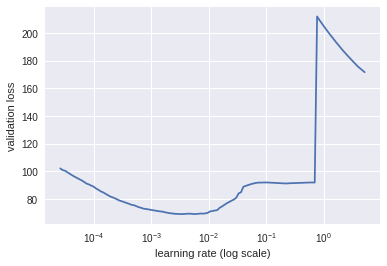

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=2, use_clr=(10, 10))
learn.save('fz')

  1%|          | 1/145 [00:06<16:05,  6.70s/it, loss=146]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   clas_metric bb_metric  
    0      53.240019  39.675418  0.79896    25.424594 
    1      44.515194  36.6847    0.816724   24.277196 


In [0]:
learn.unfreeze()
lrs = np.array([lr / 100, lr / 10, lr])
learn.fit(lrs, 1, cycle_len=2, use_clr=(20, 10))
learn.save('lrg_od')

  0%|          | 0/145 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   clas_metric bb_metric  
    0      48.056418  37.632276  0.807192   24.481316 
    1      37.165874  34.25995   0.832322   22.201957 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


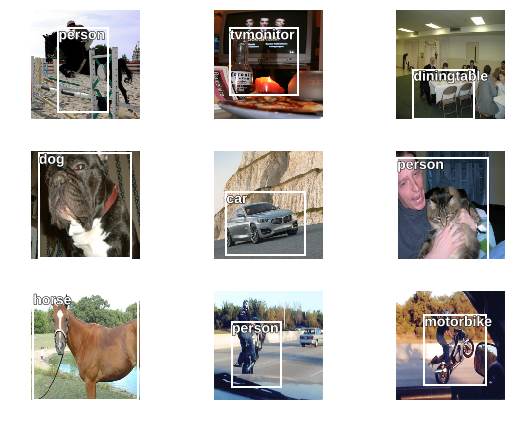

In [0]:
x, y = next(iter(md.val_dl))
yp = predict_batch(learn.model, x)
bb_p, clas_p = yp[:, :4], yp[:, 4:]
bb = F.sigmoid(bb_p) * sz
clas = torch.max(F.log_softmax(clas_p), dim=1)[1]
x = md.val_ds.ds.denorm(x)

fig, axes = plt.subplots(3, 3, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(x[i])
  xywh = from_bb(bb[i])
  draw_bbox(ax, xywh)
  draw_txt(ax, xywh[:2], clas_md.classes[clas[i]])
  ax.axis('off')
plt.tight_layout()

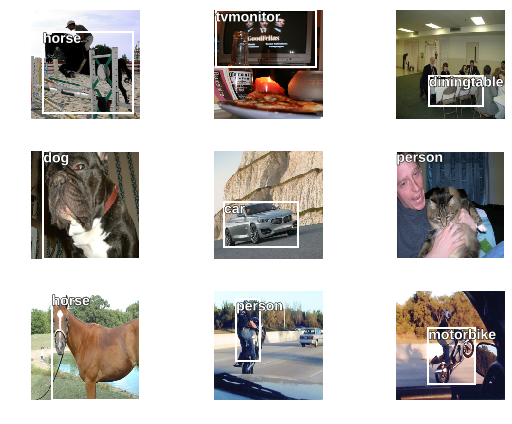

In [0]:
x, y = next(iter(md.val_dl))
x = md.val_ds.ds.denorm(x)
bb, clas = y

fig, axes = plt.subplots(3, 3, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(x[i])
  xywh = from_bb(bb[i])
  draw_bbox(ax, xywh)
  draw_txt(ax, xywh[:2], clas_md.classes[clas[i]])
  ax.axis('off')
plt.tight_layout()